# Summary

- Quantum Jump Monte Carlo

- Two level atom (initial state $\ket{\psi(0)}=\ket{gg}$)
    - [Figure 0](#Figure0) : (numerics) $n_{e}(t)$ for two trajectories
    - [Figure 1](#Figure1) : (numerics) $n_{e}(t)$ 
    - [Figure 2](#Figure2) : (exact) $n_{e}(t)$ 
    - [Figure 3](#Figure3) : (numerics vs. exact) $n_{e}(t)$ 

- Interacting atoms
    - [Figure 4-1](#Figure4-1) : (numerics) $n_{e,1}(t)$, $n_{e,2}(t)$ for $\ket{\psi(0)}=\ket{gg}$ case
    - [Figure 4](#Figure4) : (numerics) $n_{e,1}(t)$, $n_{e,2}(t)$ for $\ket{\psi(0)}=\ket{ge}$ case 
    - [Figure 5](#Figure5) : (exact) $n_{e,1}(t)$, $n_{e,2}(t)$ for $\ket{\psi(0)}=\ket{ge}$ case 
    - [Figure 6](#Figure6) : (numerics vs. exact) $n_{e,1}(t)$ for $\ket{\psi(0)}=\ket{ge}$ case 
    - [Figure 7](#Figure7) : (numerics vs. exact) $n_{e,2}(t)$ for $\ket{\psi(0)}=\ket{ge}$ case 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.optimize import fsolve
from sympy import Matrix
from tqdm import tqdm
import time

In [2]:
# For N = 1 , {|g), |e)}
# For N = 2 , {|g)|g), |g)|e), |e)|g), |e)|e)}
def phi_basis_vecs(N):
    phi = np.array([[0+0j]*(2**N)]).transpose()
    base = []
    for i in range(2**N):
        phi[i] += 1
        base.append(phi)
        phi = np.array([[0+0j]*(2**N)]).transpose()
    return base

# For N = 1 , {GG=|g)(g|, GE=|g)(e|, EG=|e)(g|, EE=|e)(e|}
# For N = 2 , {GGGG,GGGE,GGEG,GGEE,GEGG,GEGE,GEEG,GEEE,EGGG,EGGE,EGEG,EGEE,EEGG,EEGE,EEEG,EEEE}
def rho_basis_ops(N):
    zero = np.zeros((2,2), dtype = complex)
    rho = np.zeros((2,2), dtype = complex)
    base = []
    for i in range(N-1):
        rho = np.kron(rho, zero)
    for i in range(2**N):
        for j in range(2**N):
            rho[i][j] = 1
            base.append(rho)
            rho= np.zeros((rho.shape), dtype = complex)
    return base

In [3]:
def id(N):
    matrix = np.array([[1, 0],[0, 1]], dtype = complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    for i in range(N-1):
        matrix = np.kron(matrix,identity)
    return matrix

def S_x(N, n):
    s_x = np.array([[0, 1], [1, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_x)
    return matrix

def S_plus(N, n):
    s_plus =  np.array([[0, 0], [1, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_plus)
    return matrix

def S_minus(N, n):
    s_minus = np.array([[0, 1], [0, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_minus)
    return matrix

# Lindblad master equation

$\partial_{t}\rho = -i[H,\rho] +  \gamma(L\rho L^{\dagger}-\frac{1}{2}\{L^{\dagger}L,\rho \})= -i(H_{eff}\rho - \rho H^{\dagger}_{eff})+\gamma L\rho L^{\dagger}$

$H_{eff}= H - \frac{i}{2}\gamma L^{\dagger}L$

# Quantum Jump Monte Carlo 

Integrate the wavefunction

$\ket{\psi(t+\delta t)} \propto e^{-iH_{eff}\delta t}\ket{\psi(t)} = (I - i H_{eff}\delta t - \frac{1}{2}H_{eff}(\delta t)^{2}+ ...)\ket{\psi(t)}$

$\ket{\psi(t+\delta t)} \propto L\psi(t)$


# In our cases 

Two-level atom

$H = \Omega\sigma^x$

$L = \sigma^-$

$L^\dagger = \sigma^+$

Interacting atoms 

$H = \Omega(\sigma^x_1+\sigma^x_2)$

$L = \frac{1}{\sqrt{2}}\sigma^{-}_{1}+\frac{1}{\sqrt{2}}\sigma^{-}_{2}$

$L^{\dagger} = \frac{1}{\sqrt{2}}\sigma^{+}_{1}+\frac{1}{\sqrt{2}}\sigma^{+}_{2}$



In [4]:
def dagger(matrix):
    return np.transpose(np.conj(matrix))

def commutator(matrix_1, matrix_2, sign):
    if sign == 0:
        return matrix_1 @ matrix_2 - matrix_2 @ matrix_1
    else:
        return matrix_1 @ matrix_2 + matrix_2 @ matrix_1

def effective_Hamiltonian(H, gamma, L):
    return H - 1j/2 * gamma * dagger(L) @ L


# 1. Two level atom

In [5]:
# Define the system
omega = 18
gamma = omega / 3
H = omega * S_x(1,1)
L = S_minus(1,1)
H_eff = effective_Hamiltonian(H,gamma, L)

# Define the simulation parameters
total_time = 1.5
dt = 0.000015
U = expm(-1j * H_eff * dt)

def jump_probability(state):
    dp = 1- np.linalg.norm(state)
    return dp

In [6]:
N = 2700
N_ne_values = []
N_state_vectors = []
for n in tqdm(range(N)):
    
    # start a new trajectory simulation        
    time_values = []
    norm_values = []
    state_vectors = []
    ne_values = []

    current_state = phi_basis_vecs(1)[0]
    current_time = 0
    while current_time < total_time:
        
        
        # propagation
        current_state = U @ current_state

        dp = jump_probability(current_state)
        r = np.random.rand()
        if r < dp:   # jump occurs
            current_state = np.sqrt(gamma) * (L @ current_state) 
            current_state = current_state / np.sqrt(dp/dt)  # normalize the state
            state_vectors.append(current_state)
            ne = np.abs(current_state[1][0])**2
            ne_values.append(ne)          
            norm = np.linalg.norm(current_state)
            norm_values.append(norm)
        else:
            current_state = current_state/ np.sqrt(1-dp)  # normalize the state
            state_vectors.append(current_state)
            ne = np.abs(current_state[1][0])**2
            ne_values.append(ne)
            norm = np.linalg.norm(current_state)
            norm_values.append(norm)

        # update time
        time_values.append(current_time)
        current_time += dt

    N_state_vectors.append(np.array(state_vectors))
    N_ne_values.append(np.array(ne_values))

print("Simulation complete")

100%|█████████████████████████████████████| 2700/2700 [2:04:28<00:00,  2.77s/it]

Simulation complete


<a id="Figure0"></a>

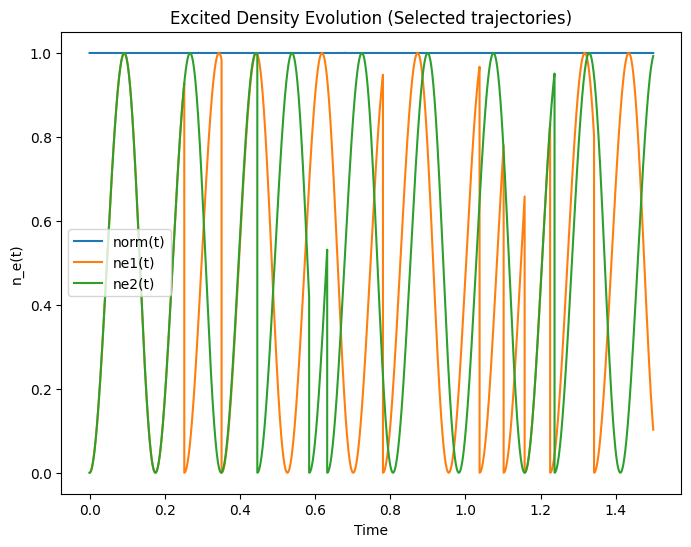

In [16]:
plt.figure(figsize=(8,6))
plt.plot(time_values, norm_values, label='norm(t)')
plt.plot(time_values, N_ne_values[0], label='ne1(t)')
plt.plot(time_values, N_ne_values[1], label='ne2(t)')
plt.title('Excited Density Evolution (Selected trajectories)')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()

Obtain $<n_{e}(t)>$ by averaging over $n_{e}(t)$ of each trajectory.

In [23]:
N_ne_sum = np.array([0+0j]*len(N_ne_values[0]), dtype=complex)
for n in range(N):
    N_ne_sum += N_ne_values[n]

N_ne_avg = N_ne_sum / N

<a id="Figure1"></a>

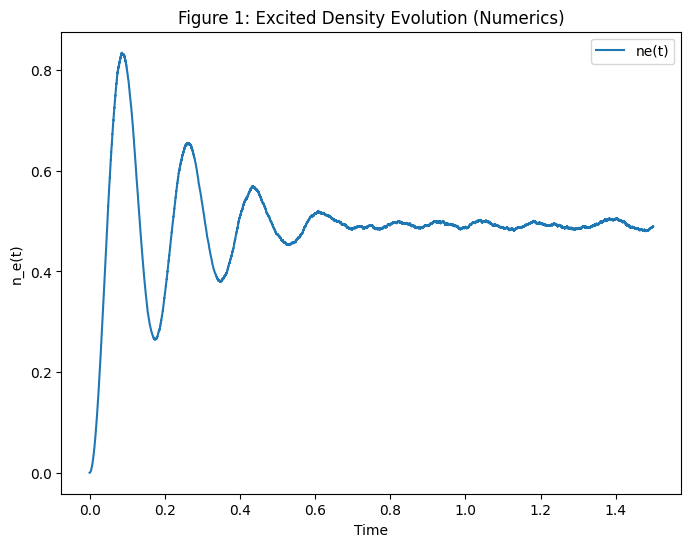

In [15]:
plt.figure(figsize=(8,6))
plt.plot(time_values, N_ne_avg, label='ne(t)')

plt.title('Figure 1: Excited Density Evolution (Numerics)')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()


# Exact result

In [10]:
# n_e of the stationary state

ne_infty = 1/ (2+gamma**2/(4*omega**2))
print("n_e(infinity)= ", ne_infty)

n_e(infinity)=  0.4931506849315069


In [11]:
# Initial state
u0 = np.array([1, 0, 0, 0], dtype=complex)

# Define the eigenvectors we've solved
u1 = np.array([1+gamma**2/(4*omega**2), 1j*gamma/(2*omega), -1j*gamma/(2*omega), 1], dtype=complex)
u2 = np.array([0, 1, 1, 0], dtype=complex)
u3 = np.array([-1, 1j*8*omega/(gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), -1j*8*omega/(gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1], dtype=complex)
u4 = np.array([-1, -1j*8*omega/(-gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1j*8*omega/(-gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1], dtype=complex)
u = [u1, u2, u3, u4]

# Define the eigenvalues we've solved
l1 = 0
l2 = -gamma/2
l3 = 1/4 * (-3*gamma - np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
l4 = 1/4 * (-3*gamma + np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
l = [l1, l2, l3, l4]

# Solve c1, c2, c3, c4 by Uc = d
U = np.zeros((4,4), dtype=complex)
d = np.zeros((4), dtype=complex)
for m in range(4):
    d[m] = dagger(u[m]) @ u0
    for n in range(4):
        U[m][n] = dagger(u[m]) @ u[n]

c = np.linalg.solve(U,d)

parameters = [c[0], c[1], c[2], c[3], l1, l2, l3, l4, u1, u2, u3, u4]

# Construct the solution rho(t) of the master equation
def Rho(parameters, t):
    state = np.array([0, 0, 0, 0], dtype=complex)
    for i in range(4):
        state += parameters[i] * np.exp(parameters[i+4]*t) * parameters[i+8] 
    return state



# Construct the excitation density ne(t)
n_e = []
n_e_infty_values = []
for t in time_values:
    norm = Rho(parameters, t)[0] + Rho(parameters, t)[3]
    n_e.append(Rho(parameters, t)[3]/norm)
    n_e_infty_values.append(ne_infty)


<a id="Figure2"></a>

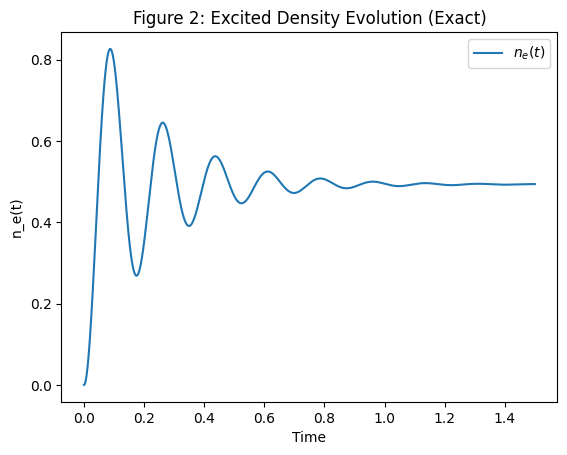

In [12]:
# Plot
n_e_exact_values = np.array(n_e)
plt.plot(time_values, n_e_exact_values, label=r'$n_e(t)$')
plt.title('Figure 2: Excited Density Evolution (Exact)')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()

# $n_{e}(t)$ numerical result vs exact result

<a id="Figure3"></a>

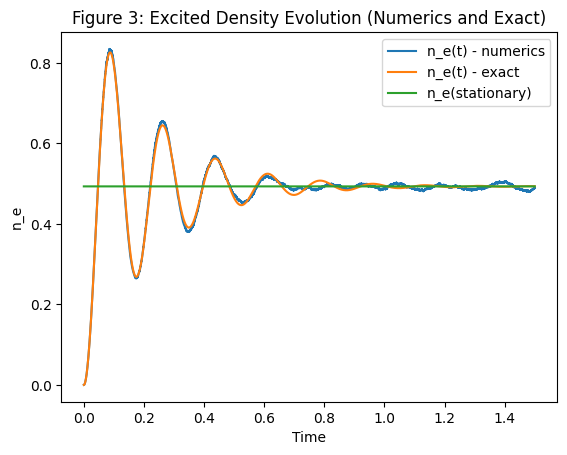

In [14]:
plt.plot(time_values, N_ne_avg, label='n_e(t) - numerics')
plt.plot(time_values, n_e_exact_values, label='n_e(t) - exact')
plt.plot(time_values, n_e_infty_values, label='n_e(stationary)')
plt.title('Figure 3: Excited Density Evolution (Numerics and Exact)')
plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()

# 2. Interacting atoms

In [17]:
# Define the system
omega = 18
gamma = 2*omega/3
H = omega * (S_x(2,1) + S_x(2,2))
L = (S_minus(2,1) + S_minus(2,2)) / np.sqrt(2)
H_eff = effective_Hamiltonian(H,gamma, L)

# Define the simulation parameters
total_time = 1.6
dt = 0.000016
U = expm(-1j * H_eff * dt)

def jump_probability(state):
    dp = 1- np.linalg.norm(state)
    return dp

In [20]:
N = 2500
N_ne1_values = []
N_ne2_values = []
N_state_vectors = []
for n in tqdm(range(N)):
    
    # start a new trajectory simulation        
    time_values = []
    norm_values = []
    state_vectors = []
    ne1_values = []
    ne2_values = []

    current_state = phi_basis_vecs(2)[0]
    current_time = 0
    while current_time < total_time:
        
        
        # propagation
        current_state = U @ current_state

        dp = jump_probability(current_state)
        r = np.random.rand()
        if r < dp:   # jump occurs
            current_state = np.sqrt(gamma) * (L @ current_state) 
            current_state = current_state / np.sqrt(dp/dt)  # normalize the state
            state_vectors.append(current_state)       
            ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
            ne1_values.append(ne1) 
            ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
            ne2_values.append(ne2)
            norm = np.linalg.norm(current_state)
            norm_values.append(norm)
        else:
            current_state = current_state/ np.sqrt(1-dp)  # normalize the state
            state_vectors.append(current_state)
            ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
            ne1_values.append(ne1) 
            ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
            ne2_values.append(ne2)
            norm = np.linalg.norm(current_state)
            norm_values.append(norm)

        # update time
        time_values.append(current_time)
        current_time += dt

    N_state_vectors.append(np.array(state_vectors))
    N_ne1_values.append(np.array(ne1_values))
    N_ne2_values.append(np.array(ne2_values))

print("Simulation complete")

100%|█████████████████████████████████████| 2500/2500 [2:28:14<00:00,  3.56s/it]

Simulation complete


<a id="Figure4-1"></a>

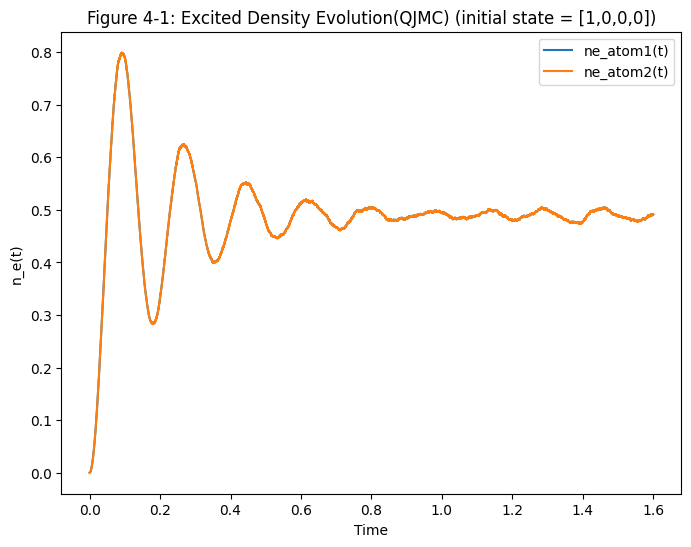

In [22]:
N_ne1_sum = np.array([0+0j]*len(N_ne1_values[0]), dtype=complex)
N_ne2_sum = np.array([0+0j]*len(N_ne2_values[0]), dtype=complex)
for n in range(N):
    N_ne1_sum += N_ne1_values[n]
    N_ne2_sum += N_ne2_values[n]

N_ne1_avg = N_ne1_sum / N
N_ne2_avg = N_ne2_sum / N


plt.figure(figsize=(8,6))
plt.plot(time_values, N_ne1_avg, label='ne_atom1(t)')
plt.plot(time_values, N_ne2_avg, label='ne_atom2(t)')

plt.title('Figure 4-1: Excited Density Evolution(QJMC) (initial state = [1,0,0,0])')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()

In [18]:
N = 2700
N_ne1_values = []
N_ne2_values = []
N_state_vectors = []
for n in tqdm(range(N)):
    
    # start a new trajectory simulation        
    time_values = []
    norm_values = []
    state_vectors = []
    ne1_values = []
    ne2_values = []

    current_state = phi_basis_vecs(2)[1]
    current_time = 0
    while current_time < total_time:
        
        
        # propagation
        current_state = U @ current_state

        dp = jump_probability(current_state)
        r = np.random.rand()
        if r < dp:   # jump occurs
            current_state = np.sqrt(gamma) * (L @ current_state) 
            current_state = current_state / np.sqrt(dp/dt)  # normalize the state
            state_vectors.append(current_state)       
            ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
            ne1_values.append(ne1) 
            ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
            ne2_values.append(ne2)
            norm = np.linalg.norm(current_state)
            norm_values.append(norm)
        else:
            current_state = current_state/ np.sqrt(1-dp)  # normalize the state
            state_vectors.append(current_state)
            ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
            ne1_values.append(ne1) 
            ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
            ne2_values.append(ne2)
            norm = np.linalg.norm(current_state)
            norm_values.append(norm)

        # update time
        time_values.append(current_time)
        current_time += dt

    N_state_vectors.append(np.array(state_vectors))
    N_ne1_values.append(np.array(ne1_values))
    N_ne2_values.append(np.array(ne2_values))

print("Simulation complete")

100%|█████████████████████████████████████| 2700/2700 [2:25:26<00:00,  3.23s/it]

Simulation complete


<a id="Figure4"></a>

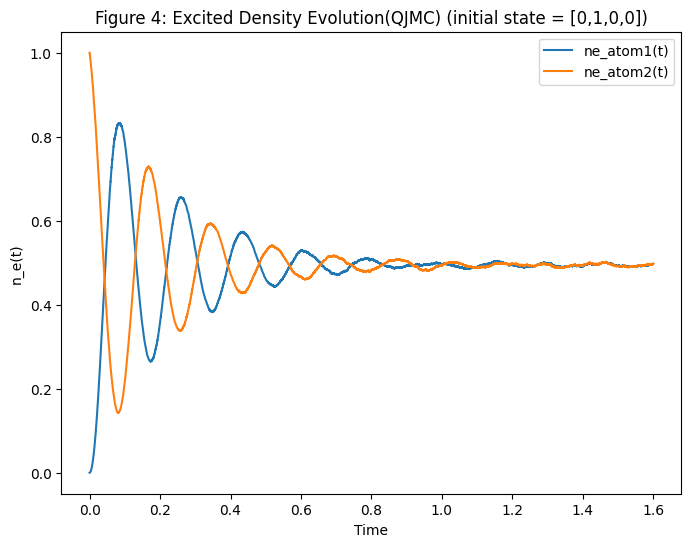

In [19]:
N_ne1_sum = np.array([0+0j]*len(N_ne1_values[0]), dtype=complex)
N_ne2_sum = np.array([0+0j]*len(N_ne2_values[0]), dtype=complex)
for n in range(N):
    N_ne1_sum += N_ne1_values[n]
    N_ne2_sum += N_ne2_values[n]

N_ne1_avg = N_ne1_sum / N
N_ne2_avg = N_ne2_sum / N


plt.figure(figsize=(8,6))
plt.plot(time_values, N_ne1_avg, label='ne_atom1(t)')
plt.plot(time_values, N_ne2_avg, label='ne_atom2(t)')

plt.title('Figure 4: Excited Density Evolution(QJMC) (initial state = [0,1,0,0])')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()

# Compared to exact result:

In [18]:
# Build the matrix representation of the Lindbladian superoperator
gamma = omega/3

def Lind(rho):
    L1 = commutator(S_x(2,1)+S_x(2,2), rho, 0)
    L2 = L @ rho @ dagger(L) - 1/2 * commutator(dagger(L) @ L, rho, 1)
    return -1j * omega * L1 + 2 * gamma * L2

M2 = np.zeros((16,16),dtype=complex)
for m in range(16):
    for n in range(16):
        M2[m][n] = np.trace( dagger(rho_basis_ops(2)[m]) @ Lind(rho_basis_ops(2)[n]))

In [21]:
# Calculate eigenvalues and eigenvectors by sympy module
M2 = Matrix(M2)
eigenvalues = M2.eigenvals()
eigenvectors = M2.eigenvects()

In [22]:
# Store in numpy list
vectors = []
values = []
for i in range(16):
    value = np.squeeze(np.array(eigenvectors[i][0]).astype(complex))
    vector = np.squeeze(np.array(eigenvectors[i][2]).astype(complex))
    values.append(value)
    vectors.append(vector)
values = np.squeeze(values)

In [24]:
# Set up initial state rho(0)
phi = phi_basis_vecs(2)[1]
phiphi = np.outer(phi,phi)
u0 = phiphi.reshape(16)

# Solve c1, c2, ..., c16 by Uc = d
U = np.zeros((16,16), dtype=complex)
d = np.zeros((16), dtype=complex)
for m in range(16):
    d[m] = dagger(vectors[m]) @ u0
    for n in range(16):
        U[m][n] = dagger(vectors[m]) @ vectors[n]

c = np.linalg.solve(U,d)

# Construct the full solution rho(t) and rho_ss
parameters = []
parameters.append(c)
parameters.append(values)
parameters.append(vectors)

# rho_ss and n_e(infinity)
rho_stationary = parameters[0][13]*parameters[2][13] + parameters[0][14]*parameters[2][14]
norm = rho_stationary[0]+rho_stationary[5]+rho_stationary[10]+rho_stationary[15]
n_e_1_infty = (rho_stationary[10]+rho_stationary[15])/norm
n_e_2_infty = (rho_stationary[5]+rho_stationary[15])/norm

# rho(t)
def Rho(parameters, t):
    state = np.zeros((16), dtype=complex)
    for i in range(16):
        state += parameters[0][i] * np.exp(parameters[1][i]*t) * parameters[2][i] 
    return state



# Construct the excitation density n_e_1(t), n_e_2(t)
# n_e_1 = tr(|1)(1|_1 . rho) = tr(E3E3.rho) + tr(E4E4.rho) = rho[10] + rho[15]
# n_e_2 = tr(|1)(1|_2 . rho) = tr(E2E2.rho) + tr(E4E4.rho) = rho[5] + rho[15]
n_e_1 = []
n_e_2 = []
n_e_1_infty_values = []
n_e_2_infty_values = []

for t in time_values:
    n_e_1.append( (Rho(parameters, t)[10] + Rho(parameters, t)[15]) )
    n_e_2.append( (Rho(parameters, t)[5] + Rho(parameters, t)[15]) )
    n_e_1_infty_values.append(n_e_1_infty)
    n_e_2_infty_values.append(n_e_2_infty)
    

In [36]:
# n_e1 and n_e2 of stationary state
print(n_e_1_infty,n_e_2_infty)

(0.4952923686818632-2.175711158422846e-18j) (0.4952923686818632-2.175711158422846e-18j)


<a id="Figure5"></a>

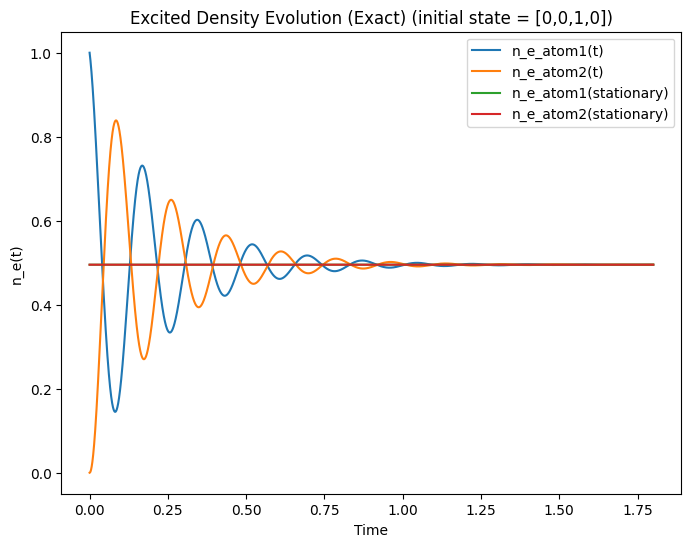

In [60]:
# Plot

plt.figure(figsize=(8,6))

plt.plot(time_values, n_e_1, label='n_e_atom1(t)')
plt.plot(time_values, n_e_2, label='n_e_atom2(t)')
plt.plot(time_values, n_e_1_infty_values, label='n_e_atom1(stationary)')
plt.plot(time_values, n_e_2_infty_values, label='n_e_atom2(stationary)')
plt.title('Figure 5: Excited Density Evolution (Exact) (initial state = [0,1,0,0])')


plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()

# Plot $n_{e,1}(t)$ and $n_{e,2}(t)$ from the QJMC and exact results together. 

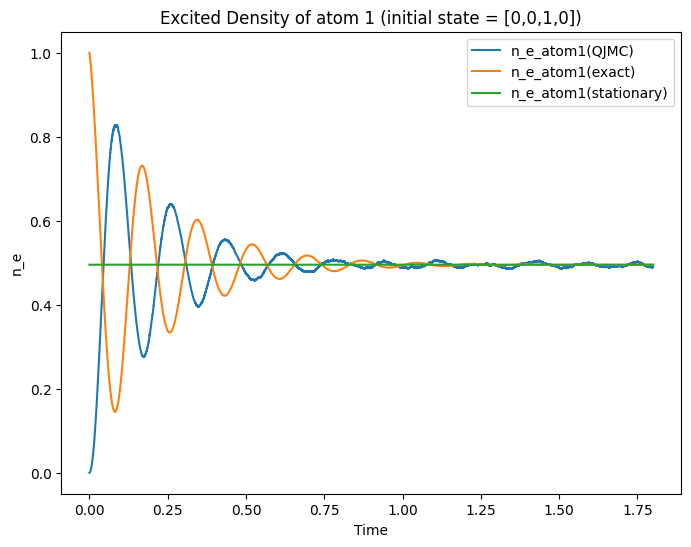

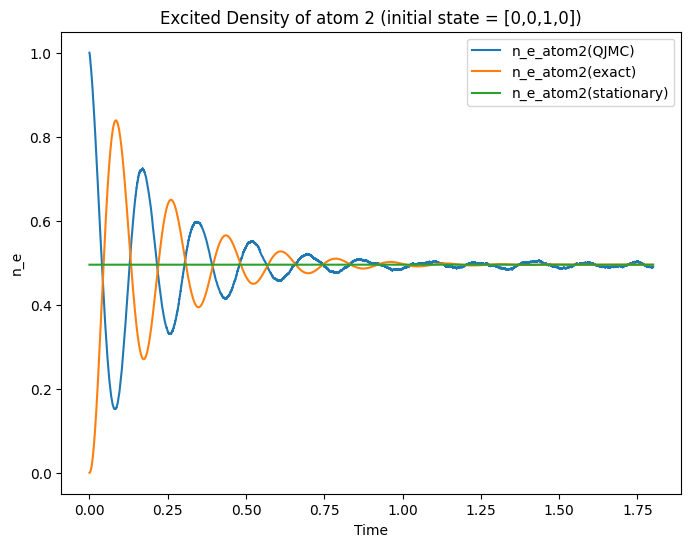

In [61]:

plt.figure(figsize=(8,6))
plt.plot(time_values, N_ne1_avg, label='n_e_atom1(QJMC)')

plt.plot(time_values, n_e_1, label='n_e_atom1(exact)')

plt.plot(time_values, n_e_1_infty_values, label='n_e_atom1(stationary)')

plt.title('Figure 6: Excited Density of atom 1 (initial state = [0,0,1,0])')

plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))



plt.plot(time_values, N_ne2_avg, label='n_e_atom2(QJMC)')
plt.plot(time_values, n_e_2, label='n_e_atom2(exact)')
plt.plot(time_values, n_e_2_infty_values, label='n_e_atom2(stationary)')
plt.title('Figure 7: Excited Density of atom 2 (initial state = [0,1,0,0])')

plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()

<a id="Figure6"></a>

<a id="Figure7"></a>